In [1]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
import sys
import sklearn
import collections
from sklearn.tree import DecisionTreeRegressor
from scipy import stats
%matplotlib inline

In [10]:
libraries = [['Numpy', np],['Pandas', pd],['Matplotlib', matplotlib],['sklearn', sklearn]]
for i in libraries:
    print('{0} Version: {1}'.format(i[0], i[1].__version__))
print("Python:", sys.version)

Numpy Version: 1.14.2
Pandas Version: 0.20.3
Matplotlib Version: 2.1.0
sklearn Version: 0.19.1
Python: 3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]


In [16]:
class random_forest_regressor:
    
    def __init__ (self, n_trees = 10, max_depth=None, n_features='sqrt', seed=None, criteria='mse'):
        """
        random forest uses bootstrapping and column randomization generate different data sets and it applies decistio trees to
        each of the generated data sets. The final prediction will be an ensemble of all the trees
        """
        
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.n_features = n_features
        self.tree_filter = []
        self.criteria = criteria
        if seed:
            self._seed = seed
            np.random.seed(seed)
            
    def pandas_to_numpy(self, X):
        
        if type(X) == type(pd.DataFrame()) or type(X) == type(pd.Series()):
            return X.as_matrix()
        elif type(X) == type(np.array([1,2,3,4])):
            return X
        else:
            return np.array(X)
        
    def handle_1d_data(self, X):
        
        if X.ndim == 1:
            return X.reshape(-1,1)
    
    def convert_to_array(self, X):
        
        X = self.pandas_to_numpy(X)
        X = self.handle_1d_data(X)
        return X
    
    def get_bagged_data(self, X, Y):
        """
        random selection of rows with replacenment. 
        """
        
        index =  np.random.choice(np.arange(len(X)), len(X))
        return X[index], Y[index]
    
    def num_columns(self, X):
        """
        you can manulally give the number of features or ask model to select 
        options: sqrt i.e it will return sqrt of number of columns in X
        """
        if isinstance(self.n_features, int):
            return self.n_features
        elif self.n_features == 'sqrt':
            return int(np.sqrt(X.shape[1]) + 0.5 )
        else:
            raise ValueError("n_features must be int or sqrt")
    
    def column_randomizer(self, X):
        """
        Selects random columns without replacenment
        """
        num_col = self.num_columns(X)
        col_filter = np.random.choice(np.arange(X.shape[1]), num_col, replace = False)
        filtered_X = self.filter_col(X, col_filter)
        return filtered_X, col_filter
    
    def filter_col(self, X, col_filter):
        
        filtered_X = X.T[col_filter]
        return filtered_X.T
    
    def fit(self, X, Y):
        
        X = self.convert_to_array(X)
        Y = self.convert_to_array(Y)
        
        for i in range(self.n_trees):
            
            bagX, bagY = self.get_bagged_data(X, Y)
            filtered_bagX, col_filter =  self.column_randomizer(bagX)
            new_tree = DecisionTreeRegressor(max_depth = self.max_depth, criterion = self.criteria)
            
            new_tree.fit(filtered_bagX, bagY)
            self.tree_filter.append((new_tree, col_filter))
            
            
    def predict(self, X):
        
        X = self.convert_to_array(X)
        self.prediction = []
        self.rf_pred = []
        for tree, col_filter in self.tree_filter:
            filtered_X = self.filter_col(X, col_filter)
            self.prediction.append(tree.predict(filtered_X))
        self.row_prediction = np.array(self.prediction).T
        
        for row in self.row_prediction:
            self.rf_pred.append(np.mean(row))
        return self.rf_pred
    
    
    def score(self, X, Y):
        
        pred = self.predict(X)
        return -1*np.mean((np.array(pred) - np.array(Y))**2)
            

            
    
    

In [3]:
def get_data():
    x = np.linspace(-10,10,300)
    y = np.cos(x)
    return x, y

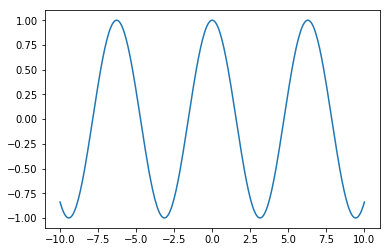

In [4]:
X,y = get_data()
plt.plot(X,y);

In [5]:
def shuffle_data(X, y):
    assert len(X) == len(y)
    permute = np.random.permutation(len(y))
    return X[permute], y[permute]

def train_test_split_manual(X, y, test_size=0.3):
    nX, ny = shuffle_data(X,y)
    split_index = int(len(X)*test_size)
    testX = nX[:split_index]
    trainX = nX[split_index:]
    testy = ny[:split_index]
    trainy = ny[split_index:]
    return trainX, testX, trainy, testy

In [7]:
X_train, X_test, y_train, y_test = train_test_split_manual(X,y,test_size=0.3)

In [17]:
rf = random_forest_regressor(n_trees=25, n_features='sqrt',seed=42)
rf.fit(X_train, y_train)

In [18]:
rf.score(X_test,y_test)

-0.001726282641852281

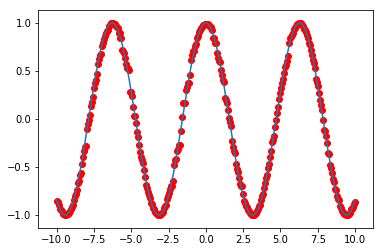

In [19]:
plt.plot(X,y)
plt.scatter(X, rf.predict(X), c = 'r')